# Chronométrage de la génération de features

Nous essayons de déterminer dans ce notebook quelles sont les étapes les plus chronophages de la génération de features, entre lecture, calcul des propriétés géométriques des points dans un nuage de points 3D, et écriture sur le disque.

Les chronométrages ont été effectués via le module `pstats`, pour un ensemble de configuration croisant différents paramètres :
- nombre de points pour lesquels les propriétés ont été calculées (5000, 10000, 50000, 100000);
- nombre de points dans le voisinage du point d'intérêt servant au calcul des propriétés géométriques (20, 50, 100);
- ensemble des propriétés considérées (alphabeta pour les coordonnées barycentriques d'après CANUPO, eigenvalues pour les métriques tirées des valeurs propres du nuage de point local, full pour l'ensemble des métriques).

## Introduction

Import des modules de travail, et lecture du fichier contenant les chronométrages :

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import seaborn as sns

%matplotlib inline

In [8]:
TIMER_FILE = Path("..", "data", "profiling", "190306", "timers", "timers.csv")

In [9]:
timers = pd.read_csv(str(TIMER_FILE))

In [10]:
timers.shape

(732, 9)

In [11]:
timers.columns

Index(['function', 'nb_points', 'nb_neighbors', 'feature_set', 'nb_calls',
       'total_time', 'total_time_per_call', 'cum_time', 'cum_time_per_call'],
      dtype='object')

## Quelles fonctions ?

On note tout d'abord que les fonctions impliquées diffèrent en fonction de l'ensemble des propriétés:

In [12]:
grouped_timers = timers.groupby(["nb_points", "nb_neighbors", "feature_set"])
grouped_timers["function"].count()

nb_points  nb_neighbors  feature_set
5000       20            alphabeta      12
                         eigenvalues    20
                         full           29
           50            alphabeta      12
                         eigenvalues    20
                         full           29
           100           alphabeta      12
                         eigenvalues    20
                         full           29
10000      20            alphabeta      12
                         eigenvalues    20
                         full           29
           50            alphabeta      12
                         eigenvalues    20
                         full           29
           100           alphabeta      12
                         eigenvalues    20
                         full           29
50000      20            alphabeta      12
                         eigenvalues    20
                         full           29
           50            alphabeta      12
                 

Il y aurait 12 fonctions différentes impliquées pour le set `alphabeta`, 20 pour le set `eigenvalues` et 29 pour le set `full`.

En détail :

In [13]:
timers.loc[timers["feature_set"] == "alphabeta"]["function"].unique()

array(['features.py:71(normalize)',
       'features.py:103(triangle_variance_space)',
       'features.py:18(<module>)', 'extract.py:48(request_tree)',
       'extract.py:70(fit_pca)', 'extract.py:87(alphabeta_features)',
       'extract.py:14(<module>)', 'extract.py:33(compute_tree)',
       '__init__.py:4(<module>)', 'io.py:14(xyz)',
       'io.py:82(write_features)', 'io.py:5(<module>)'], dtype=object)

Pour le set `alphabeta`, on trouve les fonctions de la pile d'exécution (auxquelles s'ajoutent les modules sollicités) :
- la lecture du fichier matérialisée par la fonction `xyz`.
- l'extraction de features réalisée au sein de la fonction `alphabeta_features`. Cette fonction appelle `compute_tree`, puis boucle sur l'ensemble des points considéré en appelant `request_tree`, `fit_pca`,  `normalize` et `triangle_variance_space`, cette dernière appelant.
- l'écriture du résultat via `write_features`.

In [14]:
timers.loc[timers["feature_set"] == "eigenvalues"]["function"].unique()

array(['features.py:71(normalize)',
       'features.py:103(triangle_variance_space)',
       'features.py:146(curvature_change)', 'features.py:164(linearity)',
       'features.py:182(planarity)', 'features.py:200(scattering)',
       'features.py:219(omnivariance)', 'features.py:237(anisotropy)',
       'features.py:255(eigenentropy)', 'features.py:271(val_sum)',
       'features.py:18(<module>)', 'extract.py:48(request_tree)',
       'extract.py:70(fit_pca)', 'extract.py:135(eigen_features)',
       'extract.py:14(<module>)', 'extract.py:33(compute_tree)',
       '__init__.py:4(<module>)', 'io.py:14(xyz)',
       'io.py:82(write_features)', 'io.py:5(<module>)'], dtype=object)

Par rapport au premier ensemble de fonctions, le set `eigenvalues` amène quelques différences :
- `eigen_features` remplace `alphabeta_features`
- `curvature_change`, `linearity`, `planarity`, `scattering`, `omnivariance`, `anisotropy` and `eigenentropy` apparaîssent dans la pile d'exécution, retournant à chaque itération les métriques liées aux valeurs propres du nuage de point local.

In [15]:
timers.loc[timers["feature_set"] == "full"]["function"].unique()

array(['features.py:24(accumulation_2d_neighborhood)',
       'features.py:71(normalize)',
       'features.py:103(triangle_variance_space)',
       'features.py:146(curvature_change)', 'features.py:164(linearity)',
       'features.py:182(planarity)', 'features.py:200(scattering)',
       'features.py:219(omnivariance)', 'features.py:237(anisotropy)',
       'features.py:255(eigenentropy)', 'features.py:271(val_sum)',
       'features.py:287(eigenvalue_ratio_2D)',
       'features.py:298(val_range)', 'features.py:314(std_deviation)',
       'features.py:330(radius_3D)', 'features.py:345(radius_2D)',
       'features.py:364(density_3D)', 'features.py:383(density_2D)',
       'features.py:402(verticality_coefficient)',
       'features.py:18(<module>)', 'extract.py:48(request_tree)',
       'extract.py:70(fit_pca)', 'extract.py:196(all_features)',
       'extract.py:14(<module>)', 'extract.py:33(compute_tree)',
       '__init__.py:4(<module>)', 'io.py:14(xyz)',
       'io.py:82(write_fe

Enfin, le troisième ensemble de fonction, lié au set `full` est le plus fourni. Par rapport aux sets précédents, on a les changements suivants :
- `all_features` remplace `alphabeta_features`;
- `accumulation_2d_neighborhood` est appelé une fois avant l'itération principale de la fonction, pour calculer des métriques via un quadrillage de l'espace (x, y) du nuage de point;
- de nouvelles fonctions sont appelées à chaque itération pour donner des features complémentaires: `val_sum`, `eigenvalue_ratio_2D`, `val_range`, `std_deviation`, `radius_3D`, `radius_2D`, `density_3D`, `density_2D`, `verticality_coefficient`.

## Temps par expérience

Pour avoir une idée globale du temps passé pour chaque expérience, nous pouvons faire la somme de tous les temps totaux passés dans les fonctions de lecture, traitement et écriture :

In [16]:
functions_of_interest = ['io.py:14(xyz)', 'extract.py:87(alphabeta_features)', 'extract.py:135(eigen_features)', 'extract.py:196(all_features)', 'io.py:82(write_features)']

In [17]:
function_mask = [f in functions_of_interest for f in timers["function"]]
simplified_timers = timers.loc[function_mask]

In [18]:
cum_times = simplified_timers.groupby(["nb_points", "nb_neighbors", "feature_set"])["cum_time"].sum()
cum_times.unstack()

feature_set              alphabeta  eigenvalues        full
nb_points nb_neighbors                                     
5000      20             27.071850    31.385177   33.189774
          50             28.355177    29.052108   35.588013
          100            28.617920    26.587096   30.618921
10000     20             31.306631    31.724698   41.121475
          50             29.800331    32.637111   40.757541
          100            31.255550    30.912367   40.801847
50000     20             68.645900    72.148889  125.113021
          50             66.294938    71.742480  119.733950
          100            67.359070    66.721788  108.485876
100000    20            105.152848   105.077824  184.441102
          50            101.686383   115.864284  187.289421
          100           105.685561   112.391619  192.870106

Le temps passé à générer des features est :
- moins que linéaire par rapport au nombre de points considérés
- indépendant de la taille du voisinage
- très impacté par les features complémentaires (set `full`)

In [23]:
grouped_simplified_timers = simplified_timers.groupby(["nb_points", "nb_neighbors", "feature_set", "function"])["cum_time"].sum().unstack()

In [24]:
grouped_simplified_timers["generate_features"] = np.nan
grouped_simplified_timers.reset_index(inplace=True)
grouped_simplified_timers.loc[grouped_simplified_timers["feature_set"]=="alphabeta", "generate_features"] = grouped_simplified_timers["extract.py:87(alphabeta_features)"]
grouped_simplified_timers.loc[grouped_simplified_timers["feature_set"]=="eigenvalues", "generate_features"] = grouped_simplified_timers["extract.py:135(eigen_features)"]
grouped_simplified_timers.loc[grouped_simplified_timers["feature_set"]=="full", "generate_features"] = grouped_simplified_timers["extract.py:196(all_features)"]
grouped_simplified_timers.set_index(["nb_points", "nb_neighbors", "feature_set"], inplace=True)
grouped_simplified_timers["reading"] = grouped_simplified_timers["io.py:14(xyz)"]
grouped_simplified_timers["writing"] = grouped_simplified_timers["io.py:82(write_features)"]
grouped_simplified_timers.drop(functions_of_interest, axis=1, inplace=True)

In [25]:
grouped_simplified_timers

function                            generate_features    reading    writing
nb_points nb_neighbors feature_set                                         
5000      20           alphabeta             2.023303  22.919484   2.129063
                       eigenvalues           2.245058  26.702176   2.437943
                       full                  4.883716  23.071440   5.234618
          50           alphabeta             2.381031  23.477129   2.497017
                       eigenvalues           2.706598  23.415469   2.930041
                       full                  6.041785  23.086238   6.459990
          100          alphabeta             2.565112  23.362996   2.689812
                       eigenvalues           2.401887  21.591207   2.594002
                       full                  4.593228  21.112500   4.913193
10000     20           alphabeta             4.333890  22.409256   4.563485
                       eigenvalues           4.663952  21.999113   5.061633
                       full                  9.106846  22.243198   9.771431
          50           alphabeta             4.163973  21.264841   4.371517
                       eigenvalues           5.027972  22.180662   5.428477
                       full                  8.827111  22.460997   9.469433
          100          alphabeta             4.712432  21.606080   4.937038
                       eigenvalues           4.720999  21.092009   5.099359
                       full                  9.040050  22.094400   9.667397
50000     20           alphabeta            22.798128  21.940460  23.907312
                       eigenvalues          23.964455  22.234143  25.950291
                       full                 48.822500  23.979792  52.310729
          50           alphabeta            21.862752  21.527917  22.904269
                       eigenvalues          24.096472  21.641620  26.004388
                       full                 47.399204  21.538376  50.796370
          100          alphabeta            21.843516  22.664713  22.850841
                       eigenvalues          22.621099  19.710120  24.390569
                       full                 42.830439  19.756790  45.898647
100000    20           alphabeta            40.018444  23.110365  42.024039
                       eigenvalues          41.080086  19.402173  44.595565
                       full                 79.551175  19.476871  85.413056
          50           alphabeta            40.086693  19.554998  42.044692
                       eigenvalues          46.493943  19.223508  50.146833
                       full                 81.117499  19.189889  86.982033
          100          alphabeta            42.308618  19.167737  44.209206
                       eigenvalues          44.801650  19.289202  48.300767
                       full                 83.371726  20.003544  89.494836

La dernière table montre un complément d'information intéressant. Il est possible de voir que le processus de lecture prend environ 20 secondes quelle que soit la configuration pour le nuage de points considérés (~1.9 millions de points).

Ensuite, le processus d'écriture s'avère suivre de très près le processus de génération de features: et pour cause, la génération de features s'effectue via un générateur Python, ainsi l'opération n'est faite que lorsque l'itérateur est utilisé (pendant l'écriture).

La majeure partie du temps passé correspond à la génération de features elle-même. Décomposons ce processus...

In [26]:
timers.function.unique()

array(['features.py:71(normalize)',
       'features.py:103(triangle_variance_space)',
       'features.py:18(<module>)', 'extract.py:48(request_tree)',
       'extract.py:70(fit_pca)', 'extract.py:87(alphabeta_features)',
       'extract.py:14(<module>)', 'extract.py:33(compute_tree)',
       '__init__.py:4(<module>)', 'io.py:14(xyz)',
       'io.py:82(write_features)', 'io.py:5(<module>)',
       'features.py:146(curvature_change)', 'features.py:164(linearity)',
       'features.py:182(planarity)', 'features.py:200(scattering)',
       'features.py:219(omnivariance)', 'features.py:237(anisotropy)',
       'features.py:255(eigenentropy)', 'features.py:271(val_sum)',
       'extract.py:135(eigen_features)',
       'features.py:24(accumulation_2d_neighborhood)',
       'features.py:287(eigenvalue_ratio_2D)',
       'features.py:298(val_range)', 'features.py:314(std_deviation)',
       'features.py:330(radius_3D)', 'features.py:345(radius_2D)',
       'features.py:364(density_3D)', 'feat

In [30]:
gen_feature_functions = ['extract.py:48(request_tree)',
                         'extract.py:70(fit_pca)',
                         'features.py:71(normalize)',
                         'features.py:103(triangle_variance_space)',
                         'features.py:330(radius_3D)', 'features.py:345(radius_2D)',
                         'features.py:146(curvature_change)', 'features.py:164(linearity)',
                         'features.py:182(planarity)', 'features.py:200(scattering)',
                         'features.py:219(omnivariance)', 'features.py:237(anisotropy)', 'features.py:255(eigenentropy)',
                         'features.py:271(val_sum)',
                         'features.py:287(eigenvalue_ratio_2D)',
                         'features.py:298(val_range)', 'features.py:314(std_deviation)',
                         'features.py:330(radius_3D)', 'features.py:345(radius_2D)',
                         'features.py:364(density_3D)', 'features.py:383(density_2D)',
                         'features.py:402(verticality_coefficient)']

In [31]:
gen_feature_mask = [f in gen_feature_functions for f in timers["function"]]
gen_feature_timers = timers.loc[gen_feature_mask]

In [32]:
cum_times = gen_feature_timers.groupby(["nb_points", "nb_neighbors", "feature_set"])["cum_time"].sum()
cum_times.unstack()

feature_set             alphabeta  eigenvalues       full
nb_points nb_neighbors                                   
5000      20             1.923487     2.114202   4.579186
          50             2.257155     2.542668   5.642059
          100            2.422231     2.251440   4.305617
10000     20             4.115779     4.387279   8.579049
          50             3.943653     4.721247   8.311560
          100            4.448162     4.418097   8.503158
50000     20            21.672697    22.566074  46.170822
          50            20.709182    22.635080  44.752959
          100           20.610571    21.157295  40.447161
100000    20            37.985561    38.683170  75.343264
          50            38.000127    43.723405  76.692896
          100           39.947251    41.924292  78.650826

Ces chiffres doivent être comparés avec ceux de la colonnes `generate_features`, dans la table précédente : on obtient le temps nécessaire pour la génération de features, une fois mis de côté le temps de calcul initial du KDTree.

### Ensemble `alphabeta`

In [33]:
alphabeta_feature_timers = gen_feature_timers[gen_feature_timers["feature_set"] == "alphabeta"]

In [34]:
alphabeta_feature_timers.groupby(["nb_points", "nb_neighbors", "function"])["cum_time"].mean().unstack()

function                extract.py:48(request_tree)  extract.py:70(fit_pca)  \
nb_points nb_neighbors                                                        
5000      20                               0.409968                1.429801   
          50                               0.514210                1.648349   
          100                              0.587662                1.735967   
10000     20                               0.890824                3.045669   
          50                               0.911260                2.865059   
          100                              1.101903                3.165734   
50000     20                               5.190584               15.564194   
          50                               5.266954               14.584556   
          100                              5.564224               14.220147   
100000    20                               9.260838               27.123134   
          50                               9.932579               26.548527   
          100                             11.453898               26.943963   

function                features.py:103(triangle_variance_space)  \
nb_points nb_neighbors                                             
5000      20                                            0.021146   
          50                                            0.023932   
          100                                           0.024361   
10000     20                                            0.043941   
          50                                            0.042162   
          100                                           0.045226   
50000     20                                            0.225991   
          50                                            0.224435   
          100                                           0.205718   
100000    20                                            0.405485   
          50                                            0.389138   
          100                                           0.387119   

function                features.py:71(normalize)  
nb_points nb_neighbors                             
5000      20                             0.062572  
          50                             0.070664  
          100                            0.074241  
10000     20                             0.135345  
          50                             0.125172  
          100                            0.135299  
50000     20                             0.691928  
          50                             0.633237  
          100                            0.620482  
100000    20                             1.196104  
          50                             1.129883  
          100                            1.162271

Pour le set de features `alphabeta`, seulement trois fonctions sont appelées durant la génération des features : `build_neighborhood` correspond à l'extraction des points voisins à partir du KDTree, `fitted_pca` retourne le modèle d'ACP pour le point courant et son voisinage alors que `triangle_variance_space` retourne les features.

Ces trois fonctions semblent peu influencées par la taille du voisinage, mais sont très sensibles au nombre de points considérés (relation linéaire).

### Ensemble `eigenvalues`

In [35]:
eigen_feature_timers = gen_feature_timers[gen_feature_timers["feature_set"] == "eigenvalues"]

In [36]:
grouped_eigen_feature_timers = eigen_feature_timers.groupby(["nb_points", "nb_neighbors", "function"])["cum_time"].mean().unstack()
grouped_eigen_feature_timers

function                extract.py:48(request_tree)  extract.py:70(fit_pca)  \
nb_points nb_neighbors                                                        
5000      20                               0.415167                1.471856   
          50                               0.536726                1.746820   
          100                              0.509088                1.514396   
10000     20                               0.885090                3.034346   
          50                               1.010765                3.230876   
          100                              1.016379                2.961605   
50000     20                               4.994211               15.254518   
          50                               5.329162               15.070959   
          100                              5.373338               13.732223   
100000    20                               8.789434               25.902957   
          50                              10.792813               28.653630   
          100                             11.294098               26.650384   

function                features.py:103(triangle_variance_space)  \
nb_points nb_neighbors                                             
5000      20                                            0.021697   
          50                                            0.024489   
          100                                           0.021748   
10000     20                                            0.043866   
          50                                            0.045272   
          100                                           0.041978   
50000     20                                            0.223758   
          50                                            0.217363   
          100                                           0.198836   
100000    20                                            0.388229   
          50                                            0.410482   
          100                                           0.383695   

function                features.py:146(curvature_change)  \
nb_points nb_neighbors                                      
5000      20                                     0.001202   
          50                                     0.001334   
          100                                    0.001152   
10000     20                                     0.002490   
          50                                     0.002693   
          100                                    0.002150   
50000     20                                     0.011911   
          50                                     0.013452   
          100                                    0.010936   
100000    20                                     0.019161   
          50                                     0.023603   
          100                                    0.022191   

function                features.py:164(linearity)  \
nb_points nb_neighbors                               
5000      20                              0.005266   
          50                              0.005889   
          100                             0.005287   
10000     20                              0.011121   
          50                              0.011115   
          100                             0.010196   
50000     20                              0.052636   
          50                              0.053330   
          100                             0.049873   
100000    20                              0.092183   
          50                              0.098616   
          100                             0.092003   

function                features.py:182(planarity)  \
nb_points nb_neighbors                               
5000      20                              0.004206   
          50                              0.004556   
          100                             0.004087   
10000     20                              0.008273   
    

En plus des trois fonctions décrites pour l'ensemble de features `alphabeta`, s'ajoute la fonction `compute_3D_features`, qui donne un ensemble de features tirés des valeurs propres du nuage de point local.

Globalement, les conclusions sont les mêmes que précédemment : la relation linéaire avec le nombre de points explique l'essentiel des évolutions en termes de temps de calcul. A noter que les trois premières fonctions présentent des temps d'exécution très proches de ceux obtenus pour le précédent ensemble de features.

### Ensemble `full`

In [37]:
full_feature_timers = gen_feature_timers[gen_feature_timers["feature_set"] == "full"]

In [38]:
grouped_full_feature_timers = full_feature_timers.groupby(["nb_points", "nb_neighbors", "function"])["cum_time"].mean().unstack()

In [39]:
columns1 = grouped_eigen_feature_timers.columns
columns1

Index(['extract.py:48(request_tree)', 'extract.py:70(fit_pca)',
       'features.py:103(triangle_variance_space)',
       'features.py:146(curvature_change)', 'features.py:164(linearity)',
       'features.py:182(planarity)', 'features.py:200(scattering)',
       'features.py:219(omnivariance)', 'features.py:237(anisotropy)',
       'features.py:255(eigenentropy)', 'features.py:271(val_sum)',
       'features.py:71(normalize)'],
      dtype='object', name='function')

In [40]:
grouped_full_feature_timers[columns1]

function                extract.py:48(request_tree)  extract.py:70(fit_pca)  \
nb_points nb_neighbors                                                        
5000      20                               0.502277                3.206183   
          50                               0.669434                3.931371   
          100                              0.539572                2.954817   
10000     20                               0.970310                5.973617   
          50                               1.000161                5.753225   
          100                              1.096272                5.809225   
50000     20                               5.809039               31.772603   
          50                               6.045233               30.456249   
          100                              5.771348               27.205166   
100000    20                               9.557457               51.774163   
          50                              10.786229               51.754019   
          100                             12.090031               52.224305   

function                features.py:103(triangle_variance_space)  \
nb_points nb_neighbors                                             
5000      20                                            0.023816   
          50                                            0.027858   
          100                                           0.021738   
10000     20                                            0.044997   
          50                                            0.043039   
          100                                           0.042228   
50000     20                                            0.238621   
          50                                            0.223161   
          100                                           0.200525   
100000    20                                            0.396074   
          50                                            0.396573   
          100                                           0.390096   

function                features.py:146(curvature_change)  \
nb_points nb_neighbors                                      
5000      20                                     0.002110   
          50                                     0.002842   
          100                                    0.001801   
10000     20                                     0.004007   
          50                                     0.003681   
          100                                    0.003545   
50000     20                                     0.020593   
          50                                     0.019325   
          100                                    0.015958   
100000    20                                     0.029881   
          50                                     0.029822   
          100                                    0.029865   

function                features.py:164(linearity)  \
nb_points nb_neighbors                               
5000      20                              0.005762   
          50                              0.006867   
          100                             0.005290   
10000     20                              0.011490   
          50                              0.010772   
          100                             0.010694   
50000     20                              0.059004   
          50                              0.054727   
          100                             0.047913   
100000    20                              0.098925   
          50                              0.097215   
          100                             0.100721   

function                features.py:182(planarity)  \
nb_points nb_neighbors                               
5000      20                              0.004588   
          50                              0.005151   
          100                             0.004176   
10000     20                              0.008604   
    

En reprenant les fonctions déjà rencontrées dans l'ensemble précédent, il est possible de voir que :
- la relation linéaire entre le nombre de points et le temps d'exécution est là aussi visible ;
- le nombre de voisin n'occasionne pas d'écart significatif, mais la taille du jeu de donneés est certainement trop faible pour mettre en valeur un écart potentiel ;
- les temps d'exécution entre cet ensemble de features et les précédents, bien que du même ordre de grandeur, montrent une augmentation notable, en particulier pour l'ACP qui est appelée deux fois pour le dernier ensemble de features (données 3D, et projection 2D sur le plan (x, y)).

En réalité, la majeure partie de l'écart entre ce set de features et les précédents vient des fonctions qui ne sont appelées que pour l'ensemble `full`.

In [41]:
grouped_full_feature_timers.drop(columns1, axis=1)

function                features.py:287(eigenvalue_ratio_2D)  \
nb_points nb_neighbors                                         
5000      20                                        0.004226   
          50                                        0.004989   
          100                                       0.003845   
10000     20                                        0.008147   
          50                                        0.007003   
          100                                       0.007559   
50000     20                                        0.041063   
          50                                        0.039762   
          100                                       0.032043   
100000    20                                        0.064446   
          50                                        0.064506   
          100                                       0.063121   

function                features.py:298(val_range)  \
nb_points nb_neighbors                               
5000      20                              0.085911   
          50                              0.099873   
          100                             0.077659   
10000     20                              0.157051   
          50                              0.150106   
          100                             0.155236   
50000     20                              0.809938   
          50                              0.796927   
          100                             0.706983   
100000    20                              1.339553   
          50                              1.349076   
          100                             1.372218   

function                features.py:314(std_deviation)  \
nb_points nb_neighbors                                   
5000      20                                  0.259762   
          50                                  0.314878   
          100                                 0.237114   
10000     20                                  0.487574   
          50                                  0.468732   
          100                                 0.472443   
50000     20                                  2.597224   
          50                                  2.468729   
          100                                 2.230598   
100000    20                                  4.267072   
          50                                  4.225465   
          100                                 4.210113   

function                features.py:330(radius_3D)  \
nb_points nb_neighbors                               
5000      20                              0.045546   
          50                              0.053337   
          100                             0.042356   
10000     20                              0.084857   
          50                              0.080954   
          100                             0.082080   
50000     20                              0.443961   
          50                              0.433741   
          100                             0.379257   
100000    20                              0.715583   
          50                              0.747798   
          100                             0.750205   

function                features.py:345(radius_2D)  \
nb_points nb_neighbors                               
5000      20                              0.137721   
          50                              0.167375   
          100                             0.144080   
10000     20                              0.259284   
          50                              0.255995   
          100                             0.282183   
50000     20                              1.360491   
          50                              1.348174   
          100                             1.331637   
100000    20                              2.250572   
          50                              2.319385   
          100                             2.611797   

function           

A la vue de ces derniers chiffres, les conclusions suivantes s'imposent :
- la fonction `accumulation_2d_neighborhood` a un faible coût, légèrement dépendant du nombre de points.
- les temps d'exécution des fonctions `compute_2D_features`,  `verticality_coefficient`, `compute_3D_properties` et `compute_2D_properties` présentent une relation linéaire avec le nombre de points. Les deux dernières sont plus coûteuses en temps de calcul, leur intérêt devra donc être évalué avec d'autant plus de soin au moment du clustering. A noter que `compute_2D_properties` est également impactée par la quantité de points dans le voisinage (elle contient un calcul des distances du point d'intérêt vis-à-vis de chacun de ses voisins).

## Résumé graphique

### Temps total

In [42]:
graph_functions = ["io.py:14(xyz)",
                   "features.py:24(accumulation_2d_neighborhood)",
                   "extract.py:33(compute_tree)",
                   "extract.py:48(request_tree)",
                   "extract.py:70(fit_pca)",
                   "features.py:71(normalize)",
                   "features.py:103(triangle_variance_space)",
                   "features.py:146(curvature_change)",
                   "features.py:164(linearity)",
                   "features.py:182(planarity)",
                   "features.py:200(scattering)",
                   "features.py:219(omnivariance)",
                   "features.py:237(anisotropy)",
                   "features.py:255(eigenentropy)",
                   "features.py:271(val_sum)",
                   "features.py:287(eigenvalue_ratio_2D)",
                   "features.py:298(val_range)",
                   "features.py:314(std_deviation)",
                   "features.py:330(radius_3D)",
                   "features.py:345(radius_2D)",
                   "features.py:364(density_3D)",
                   "features.py:383(density_2D)",
                   "features.py:402(verticality_coefficient)",
                   "io.py:82(write_features)"]

In [43]:
graph_mask = np.logical_and(np.logical_and(timers["nb_points"] == 100000, timers["feature_set"] == "full"),
                            [f in graph_functions for f in timers["function"]])
graph_timers = timers.loc[graph_mask]
graph_timers.drop(["nb_points", "feature_set"], axis=1, inplace=True)

/home/rde/.virtualenvs/univers/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


/home/rde/.virtualenvs/univers/lib/python3.7/site-packages/seaborn/categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


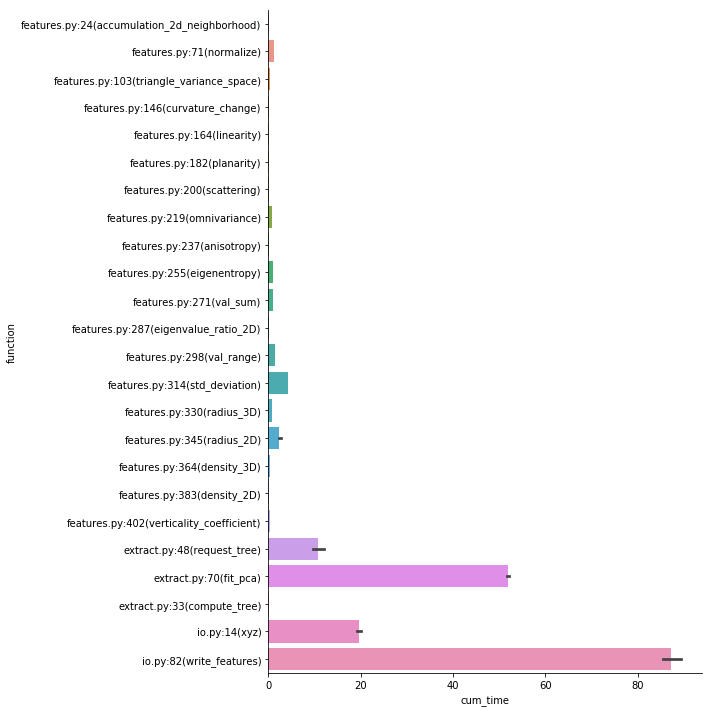

In [44]:
g = sns.catplot("cum_time", "function", data=graph_timers, kind="bar", size=10, height=2)

In [45]:
g.savefig("../docs/images/generation_feature_cum_time.png")

### Temps par itération

In [46]:
graph_iter_functions = ["extract.py:48(request_tree)",
                        "extract.py:70(fit_pca)",
                        "features.py:71(normalize)",
                        "features.py:103(triangle_variance_space)",
                        "features.py:146(curvature_change)",
                        "features.py:164(linearity)",
                        "features.py:182(planarity)",
                        "features.py:200(scattering)",
                        "features.py:219(omnivariance)",
                        "features.py:237(anisotropy)",
                        "features.py:255(eigenentropy)",
                        "features.py:271(val_sum)",
                        "features.py:287(eigenvalue_ratio_2D)",
                        "features.py:298(val_range)",
                        "features.py:314(std_deviation)",
                        "features.py:330(radius_3D)",
                        "features.py:345(radius_2D)",
                        "features.py:364(density_3D)",
                        "features.py:383(density_2D)",
                        "features.py:402(verticality_coefficient)"]

In [47]:
graph_iter_mask = np.logical_and(timers["feature_set"] == "full",
                                 [f in graph_iter_functions for f in timers["function"]])
graph_iter_timers = timers.loc[graph_iter_mask]
graph_iter_timers.drop(["feature_set"], axis=1, inplace=True)

/home/rde/.virtualenvs/univers/lib/python3.7/site-packages/seaborn/categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


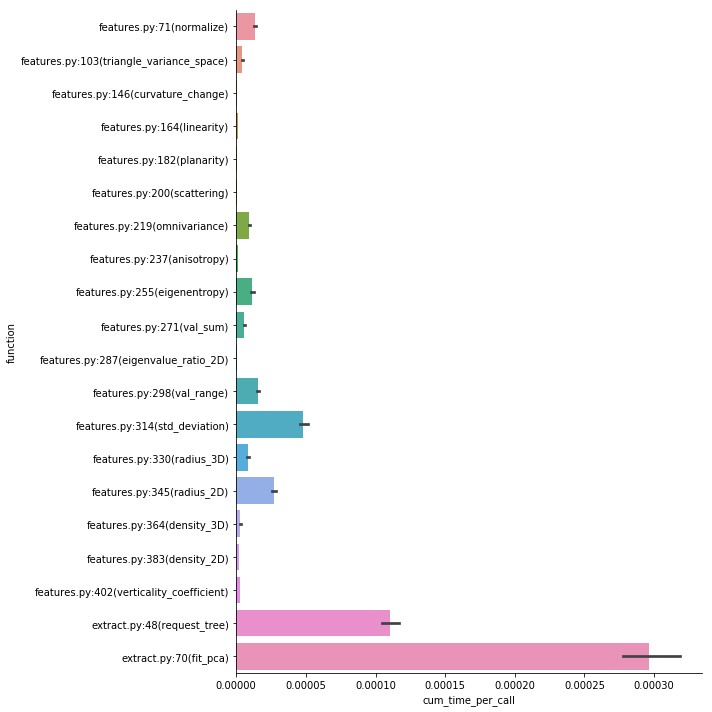

In [48]:
g = sns.catplot("cum_time_per_call", "function", data=graph_iter_timers, kind="bar", size=10, height=2)

In [49]:
g.savefig("../docs/images/generation_feature_cum_time_per_call.png")